In [1]:
#ResNet-50

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

ROOT = r'E:\Machine_Learning\dataset\image-identification\Waste-picture'
TRAIN_RATIO = 0.8
images_dir = r'E:\Machine_Learning\dataset\image-identification\Waste-picture\waste-picture\image'
train_dir = os.path.join(ROOT,'train')
test_dir = os.path.join(ROOT,'test')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)


for c in classes:
    class_dir = os.path.join(images_dir,c)

    images = os.listdir(class_dir)

    n_train = int(len(images)*TRAIN_RATIO)

    train_images = images[:n_train]
    test_images = images[n_train:]

    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)

    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image)
        shutil.copyfile(image_src, image_dst)

    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image)
        shutil.copyfile(image_src, image_dst)

D:\anacoda\anacoda-install\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anacoda\anacoda-install\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\anacoda\anacoda-install\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
train_data = datasets.ImageFolder(root=train_dir,
                                  transform = transforms.ToTensor())
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds :{stds}')

D:\anacoda\anacoda-install\lib\site-packages\PIL\TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Calculated means: tensor([0.6497, 0.6017, 0.5495])
Calculated stds :tensor([nan, nan, nan])


In [3]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [4]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [5]:
#创建验证集
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [6]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 41803
Number of validation examples: 4645
Number of testing examples: 11614


In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [9]:
#图片正则化
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [10]:
#画图
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

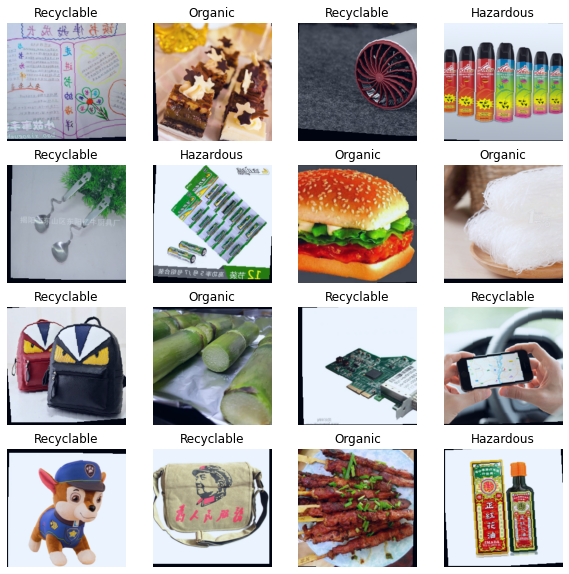

In [11]:
N_IMAGES = 16

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [12]:

#定义模型
class ResNet(nn.Module):
    def __init__(self,config, output_dim):
        super().__init__()

        block, n_block, channels = config
        self.in_channels = channels[0]

        assert len(n_block) == len(channels) == 4

        self.conv1 = nn.Conv2d(3,self.in_channels, kernel_size= 7, stride=2,padding=3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.layer1 = self.get_resnet_layer(block, n_block[0],channels[0])
        self.layer2 = self.get_resnet_layer(block,n_block[1],channels[1],stride =2)
        self.layer3 = self.get_resnet_layer(block,n_block[2],channels[2],stride =2)
        self.layer4 = self.get_resnet_layer(block,n_block[3],channels[3],stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self,block,n_blocks,channels, stride=1):

        layers = []
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x,h


In [13]:
#定义basicBlock这类

class BasicBlock(nn.Module):

    expansion =1

    def __init__(self, in_channels, out_channels, stride =1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size= 3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels,out_channels,kernel_size=1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv,bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self,x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x


In [14]:
ResNetConfig = namedtuple('ResNetConfig',['block', 'n_blocks', 'channels'])

In [15]:
#加载ResNet18和ResNet34

resnet18_config = ResNetConfig(block=BasicBlock,
                               n_blocks=[2,2,2,2],
                               channels=[64,128,256,512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64,128,256,512])

In [16]:
#定义bottleneck block
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels,self.expansion * out_channels, kernel_size=1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU(inplace= True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1,
                             stride= stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv,bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self,x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

In [17]:
#定义ResNet50, ResNet101, ResNet152

resnet50_config = ResNetConfig(block=Bottleneck,
                               n_blocks=[3,4,6,3],
                               channels=[64,128,256,512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks=[3,4,23,3],
                                channels=[64,128,256,512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks=[3,8,36,3],
                                channels=[64,128,256,512])

In [18]:
#定义CIFAResNet

class CIFARResNet(nn.Module):
    def __init__(self,config,output_dim):
        super().__init__()

        block, layers, channels = config
        self.in_channels = channels[0]

        assert len(layers) == len(channels) == 3
        assert all([i == j*2 for i, j in zip(channels[1:], channels[:-1])])

        self.conv1 = nn.Conv2d(3,self.in_channels, kernel_size=3,stride = 1, padding =1, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        
        self.layer1 = self.get_resnet_layer(block, layers[0], channels[0])
        self.layer2 = self.get_resnet_layer(block,layers[1],channels[1],stride=2)
        self.layer3 = self.get_resnet_layer(block,layers[2],channels[2],stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
    
    def get_resnet_layer(self,block,n_blocks,channels,stride =1):
        
        layers = []
        
        if self.in_channels != channels:
            downsample = True
        else:
            downsample = False
            
        layers.append(block(self.in_channels,channels,stride, downsample))
        
        for i in range(1,n_blocks):
            layers.append(block(channels,channels))
            
        self.in_channels = channels
        
        return nn.Sequential(*layers)
    
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0],-1)
        x = self.fc(h)
        
        return x,h
    

In [19]:
#identity
class Indentity(nn.Module):
    def __init__(self,f):
        super().__init__()
        self.f = f

    def forward(self,x):
        return self.f(x)

class CIFARBasicBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size=3,
                               stride=stride, padding=1, bias= False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

        if downsample:
            identity_fn = lambda x: F.pad(x[:, :, ::2, ::2],
                                          [0,0,0,0, in_channels // 2, in_channels//2])
            downsample = Indentity(identity_fn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self,x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i 
        x = self.relu(x)
        
        return x 

In [20]:
cifar_resnet20_config = ResNetConfig(block=CIFARBasicBlock,
                                     n_blocks=[3,3,3],
                                     channels=[16,32,64])

cifar_resnet32_config = ResNetConfig(block=CIFARBasicBlock,
                                     n_blocks=[5,5,5],
                                     channels=[16,32,64])

cifar_resnet44_config = ResNetConfig(block=CIFARBasicBlock,
                                     n_blocks=[7,7,7],
                                     channels=[16,32,64])

cifar_resnet56_config = ResNetConfig(block=CIFARBasicBlock,
                                     n_blocks=[9,9,9],
                                     channels=[16,32,64])

cifar_resnet110_config = ResNetConfig(block=CIFARBasicBlock,
                                      n_blocks=[18,18,18],
                                      channels=[16,32,64])

cifar_resnet1202_config = ResNetConfig(block=CIFARBasicBlock,
                                       n_blocks=[20,20,20],
                                       channels=[16,32,64])

In [60]:
pretrained_model = models.resnet50(pretrained=False)

In [61]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [62]:
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [63]:
pretrained_model.fc = fc

In [64]:
model = ResNet(resnet50_config, OUTPUT_DIM)

In [65]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [66]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,516,228 trainable parameters


In [67]:
#训练模型

START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)

criterion = criterion.to(device)

In [68]:
#找学习率

class LRFinder:
    def __init__(self,model,optimizer,criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self,iterator, end_lr = 10, num_iter = 100,
                   smooth_f = 0.05, diverge_th =5):
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer,end_lr, num_iter)

        iterator =  IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)
            #update lr
            lr_scheduler.step()

            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1-smooth_f)*losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch = -1):
        self.end_lr =end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels
    def get_batch(self):
        return next(self)

In [69]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [70]:
#定义函数画出学习率

def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
        
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs,losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('loss')
    ax.grid(True, 'both', 'x')
    plt.show()

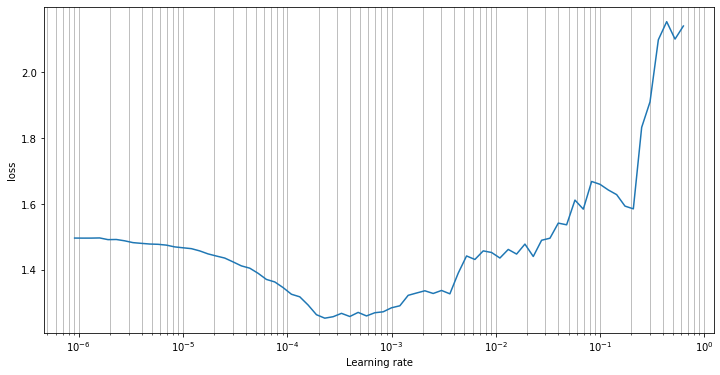

In [71]:
plot_lr_finder(lrs,losses, skip_start= 10, skip_end= 10)

In [72]:
FOUND_LR = 1e-4

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [73]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS =[p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [74]:
#计算正确率前几名
def calculate_topk_accuracy(y_pred, y, k=3):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k,1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1,-1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [75]:
def train(model, iterator, optimizier, criterion, scheduler, device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_3 = 0

    model.train()

    for (x,y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)

        loss = criterion(y_pred,y)
        acc_1, acc_3 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_3 += acc_3.item()
    
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_3 /= len(iterator)
    
    return epoch_loss, epoch_acc_1, epoch_acc_3

In [76]:
#模型评估

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_3 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            
            y_pred, _ = model(x)
            
            loss = criterion(y_pred, y)
            acc_1, acc_3 = calculate_topk_accuracy(y_pred, y)
            
            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_3 += acc_3.item()
            
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_3 /= len(iterator)
    
    return epoch_loss, epoch_acc_1, epoch_acc_3

In [77]:
#每个epoch计时
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [78]:
# 开始训练模型
import tensorflow as tf
best_valid_loss = float('inf')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.9
sess = tf.compat.v1.Session(config=config)
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc_1, train_acc_3 = train(model, train_iterator, optimizer, criterion,
                                                 scheduler, device)
    valid_loss, valid_acc_1, valid_acc_3 = evaluate(model,valid_iterator,criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
        
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch:{epoch+1:02} | Epoch Time:{epoch_mins}m {epoch_secs}s')
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | Train Acc @3: {train_acc_3*100:6.2f}%")
    print(f"\tValid Loss: {train_loss:.3f} | Valid Acc @1: {train_acc_1 * 100:6.2f}% | Valid Acc @3: {train_acc_3 * 100:6.2f}%")
    


D:\anacoda\anacoda-install\lib\site-packages\PIL\TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch:01 | Epoch Time:10m 54s
	Train Loss: 0.971 | Train Acc @1:  62.27% | Train Acc @3:  94.21%
	Valid Loss: 0.971 | Valid Acc @1:  62.27% | Valid Acc @3:  94.21%
Epoch:02 | Epoch Time:10m 0s
	Train Loss: 0.834 | Train Acc @1:  70.24% | Train Acc @3:  96.16%
	Valid Loss: 0.834 | Valid Acc @1:  70.24% | Valid Acc @3:  96.16%
Epoch:03 | Epoch Time:9m 43s
	Train Loss: 0.792 | Train Acc @1:  72.14% | Train Acc @3:  96.86%
	Valid Loss: 0.792 | Valid Acc @1:  72.14% | Valid Acc @3:  96.86%
Epoch:04 | Epoch Time:10m 19s
	Train Loss: 0.754 | Train Acc @1:  73.33% | Train Acc @3:  97.18%
	Valid Loss: 0.754 | Valid Acc @1:  73.33% | Valid Acc @3:  97.18%
Epoch:05 | Epoch Time:16m 53s
	Train Loss: 0.726 | Train Acc @1:  74.42% | Train Acc @3:  97.57%
	Valid Loss: 0.726 | Valid Acc @1:  74.42% | Valid Acc @3:  97.57%
Epoch:06 | Epoch Time:9m 49s
	Train Loss: 0.692 | Train Acc @1:  75.61% | Train Acc @3:  97.87%
	Valid Loss: 0.692 | Valid Acc @1:  75.61% | Valid Acc @3:  97.87%
Epoch:07 | Epoch Ti

In [40]:
#检验模型
#预测每个数据在测试集
def get_prediction(model, iterator):
    
    model.eval()
    
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        
        for (x,y) in iterator:
            
            x = x.to(device)
            
            y_pred, _ = model(x)
            
            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_pred.argmax(1, keepdim = True)
            
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
            
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    
    return images, labels, probs


In [41]:
images, labels, probs = get_prediction(model, test_iterator)

In [42]:
pred_labels = torch.argmax(probs, 1)

In [43]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels= classes)
    cm.plot(values_format= 'd', cmap ="OrRd", ax=ax)
    #fig.delaxes(fig.axes[1])
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 25)
    plt.ylabel('True Label', fontsize = 25)

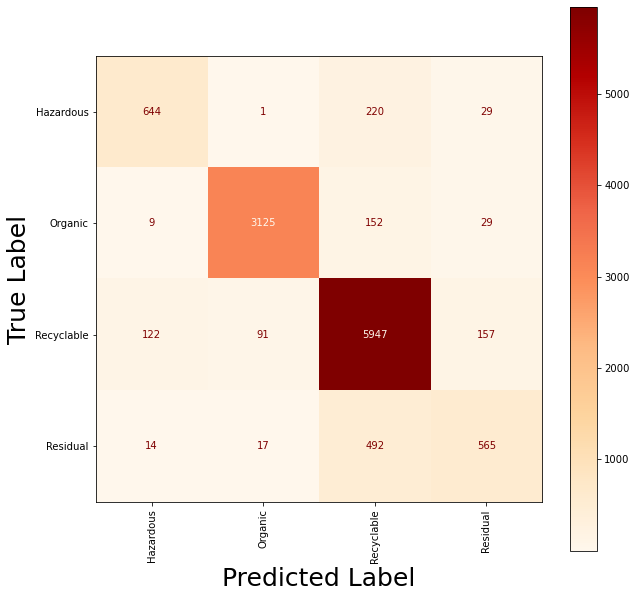

In [45]:
plot_confusion_matrix(labels, pred_labels, classes)

In [46]:
#查看预测错误的
corrects = torch.eq(labels, pred_labels)

In [47]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))
        
incorrect_examples.sort(reverse = True, key = lambda x : torch.max(x[2], dim = 0).values)

In [48]:
# 画出错误选项

def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25,20))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1,2,0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob: .3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob: .3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace = 0.4)


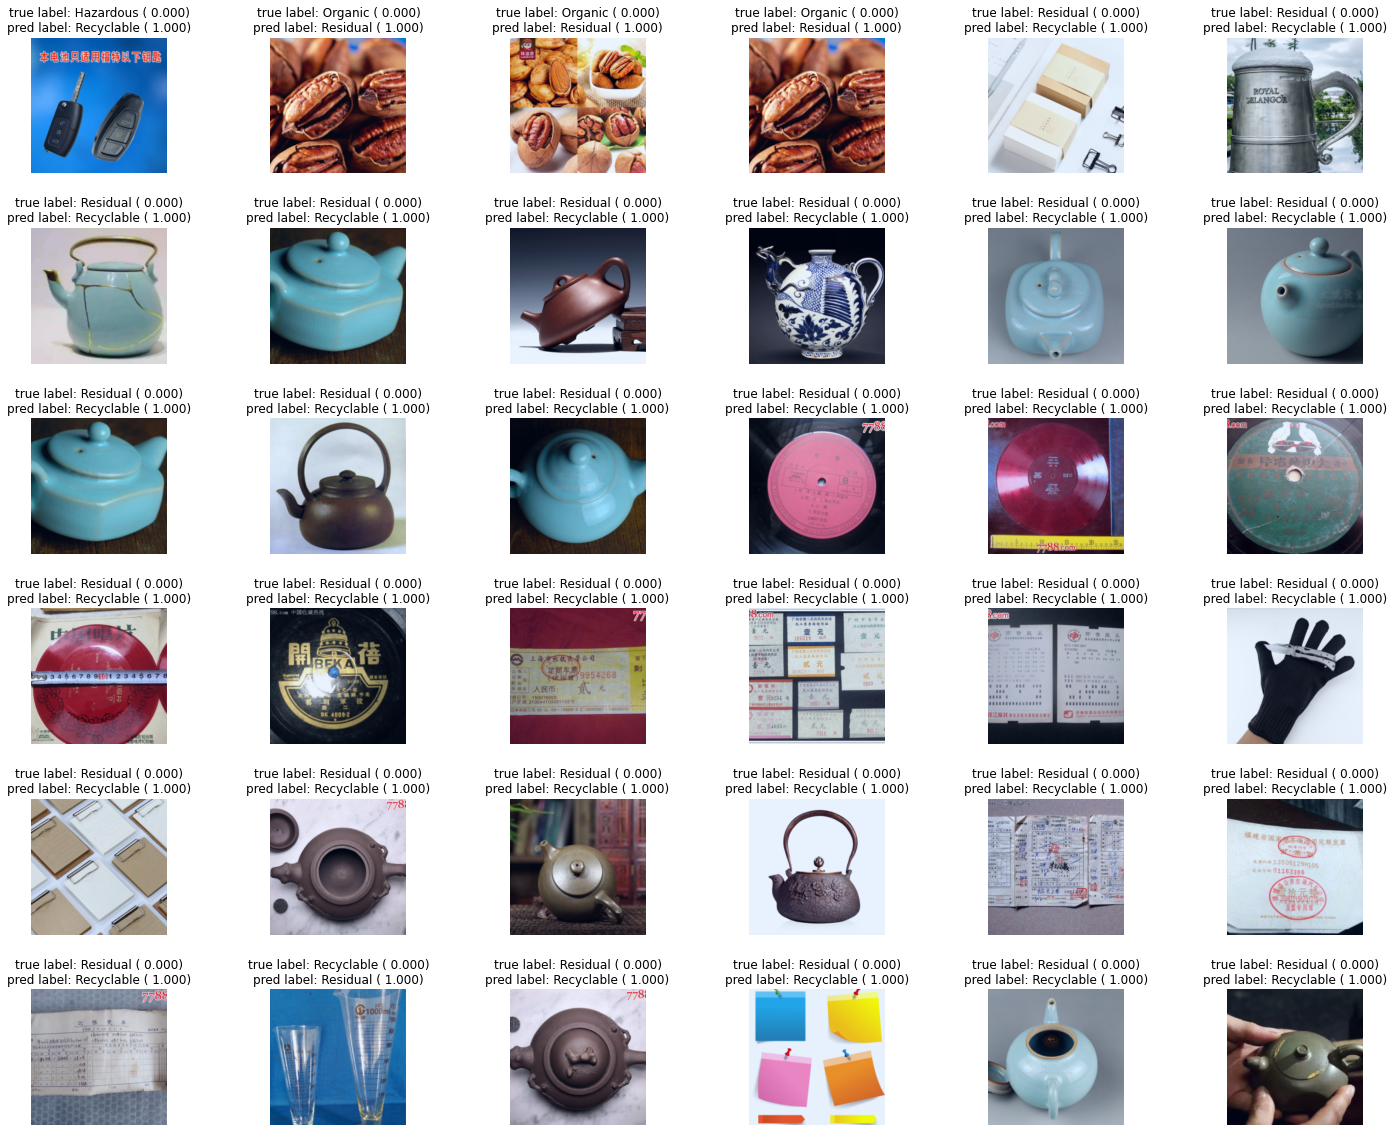

In [49]:
N_IMAGES = 36
plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [50]:
#获得特征参数
def get_representations(model, iterator):
    
    model.eval()
    
    outputs = []
    intermediates = []
    labels = []
    
    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            
            y_pred, _= model(x)
            
            outputs.append(y_pred.cpu())
            labels.append(y)
            
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)
    
    return outputs, labels

In [51]:
outputs, labels = get_representations(model, train_iterator)

D:\anacoda\anacoda-install\lib\site-packages\PIL\TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [52]:
#利用PCA 进行分类

def get_pca(data,n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [53]:
def plot_representation(data,labels, classes, n_images = None):

    if n_images is not None:
        data = data[:n_images]

    fig = plt.figure(figsize = (15,10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:,0],data[:,1], c= labels, cmap = 'coolwarm_r')
    handles, _=scatter.legend_elements(num=None)
    legend = plt.legend(handles=handles, labels=classes)

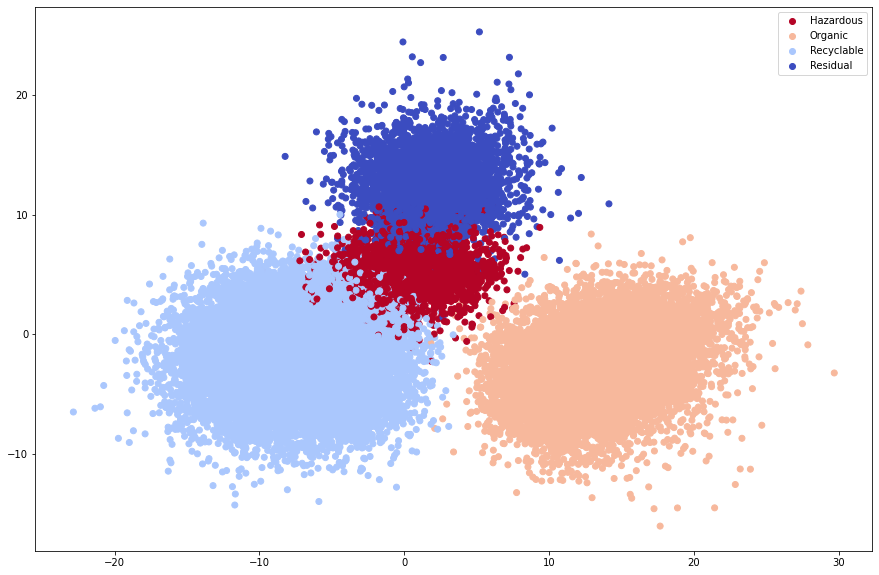

In [54]:
output_pca_data = get_pca(outputs)
plot_representation(output_pca_data,labels, classes)

In [55]:
def get_tsne(data, n_components =2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components=n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

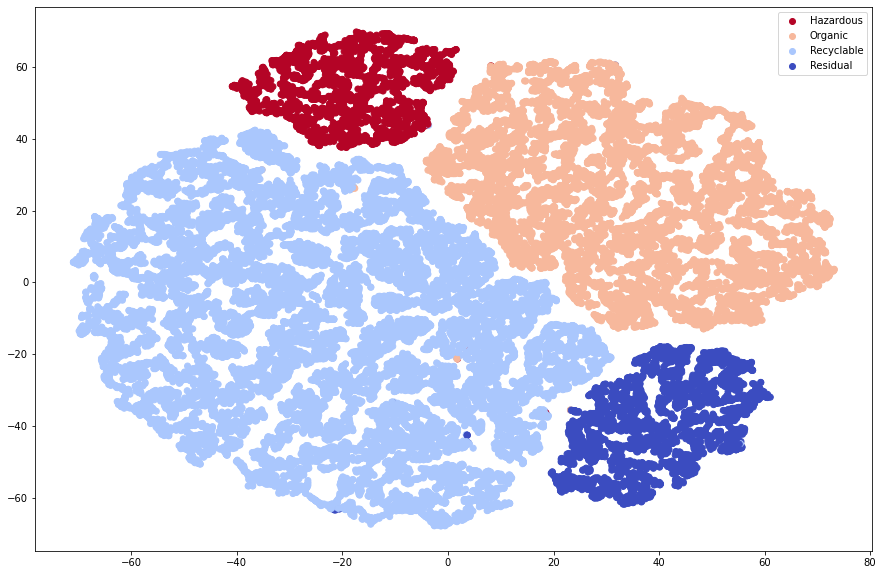

In [56]:
output_tsne_data = get_tsne(outputs)
plot_representation(output_tsne_data, labels, classes)

In [57]:
#经过每一层卷积层识别结果
def plot_filtered_images(images, filters, n_filters = None, normalize = None):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)
    fig = plt.figure(figsize = (30,30))
    for i in range(n_images):
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title("Original")
        ax.axis("off")

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter{j+1}')
            ax.axis('off')
    
    fig.subplots_adjust(hspace=-0.7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


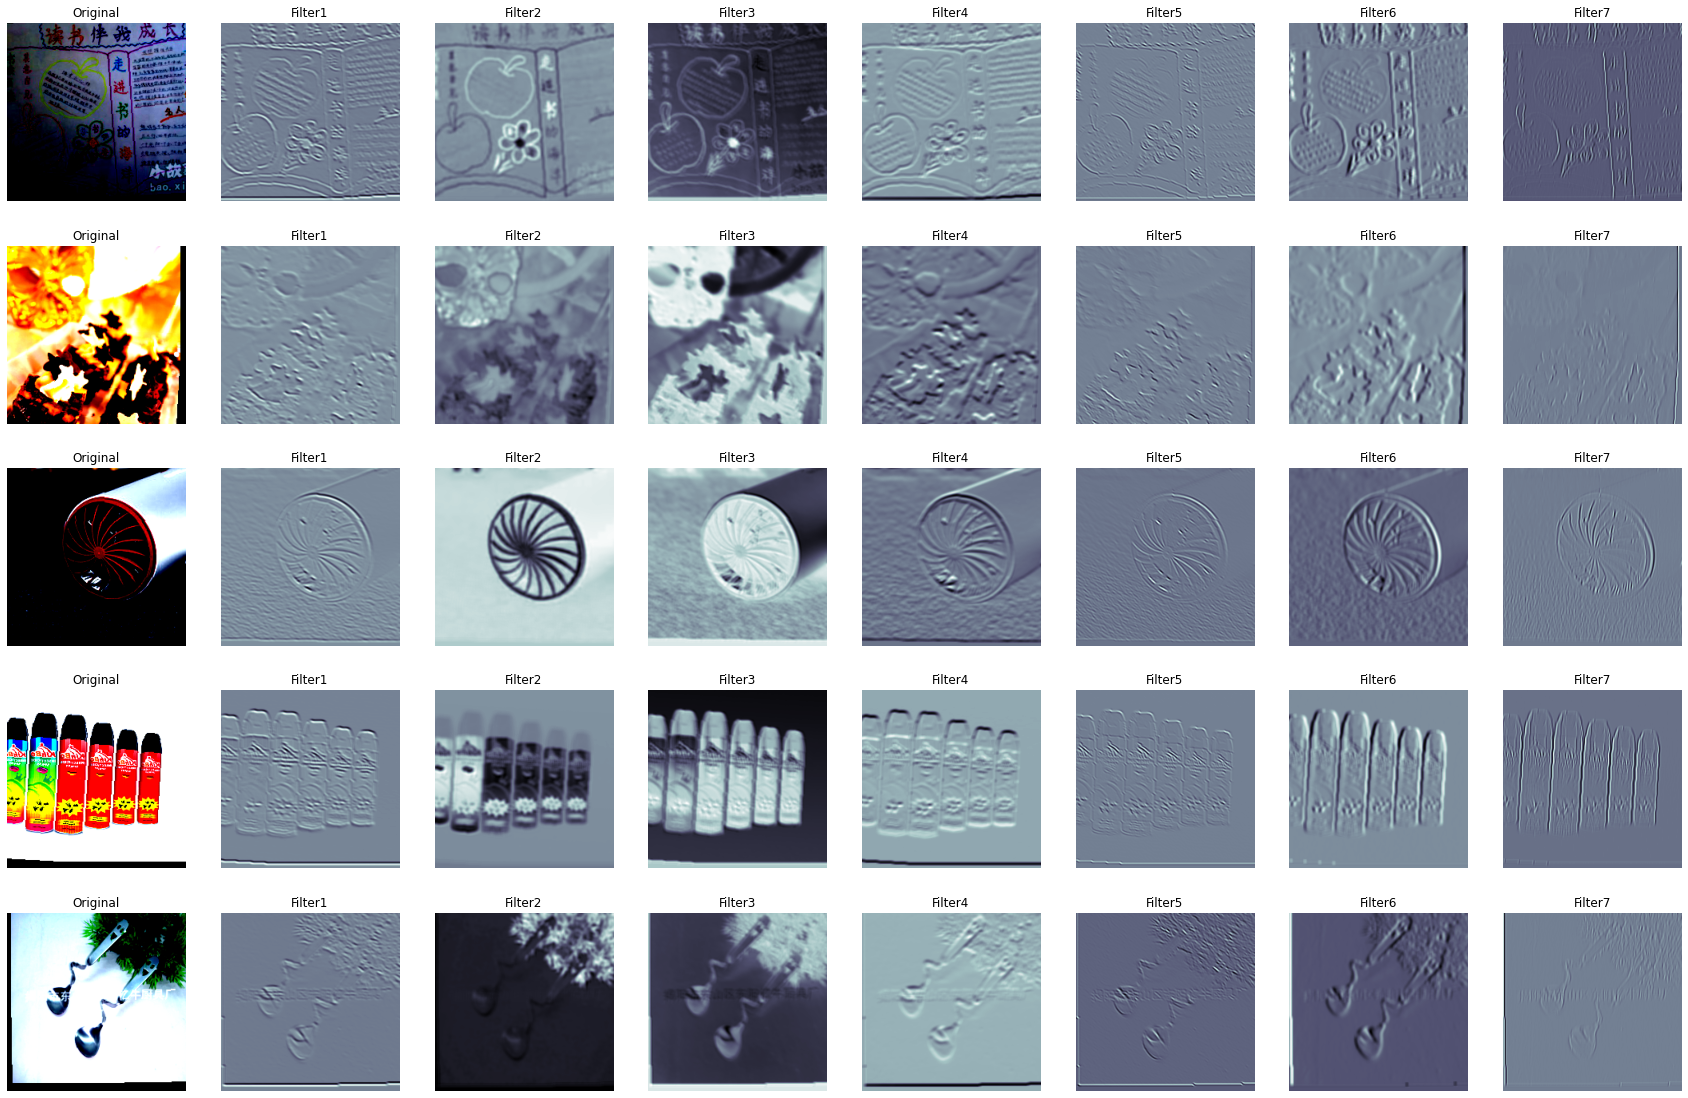

In [58]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images,filters,N_FILTERS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


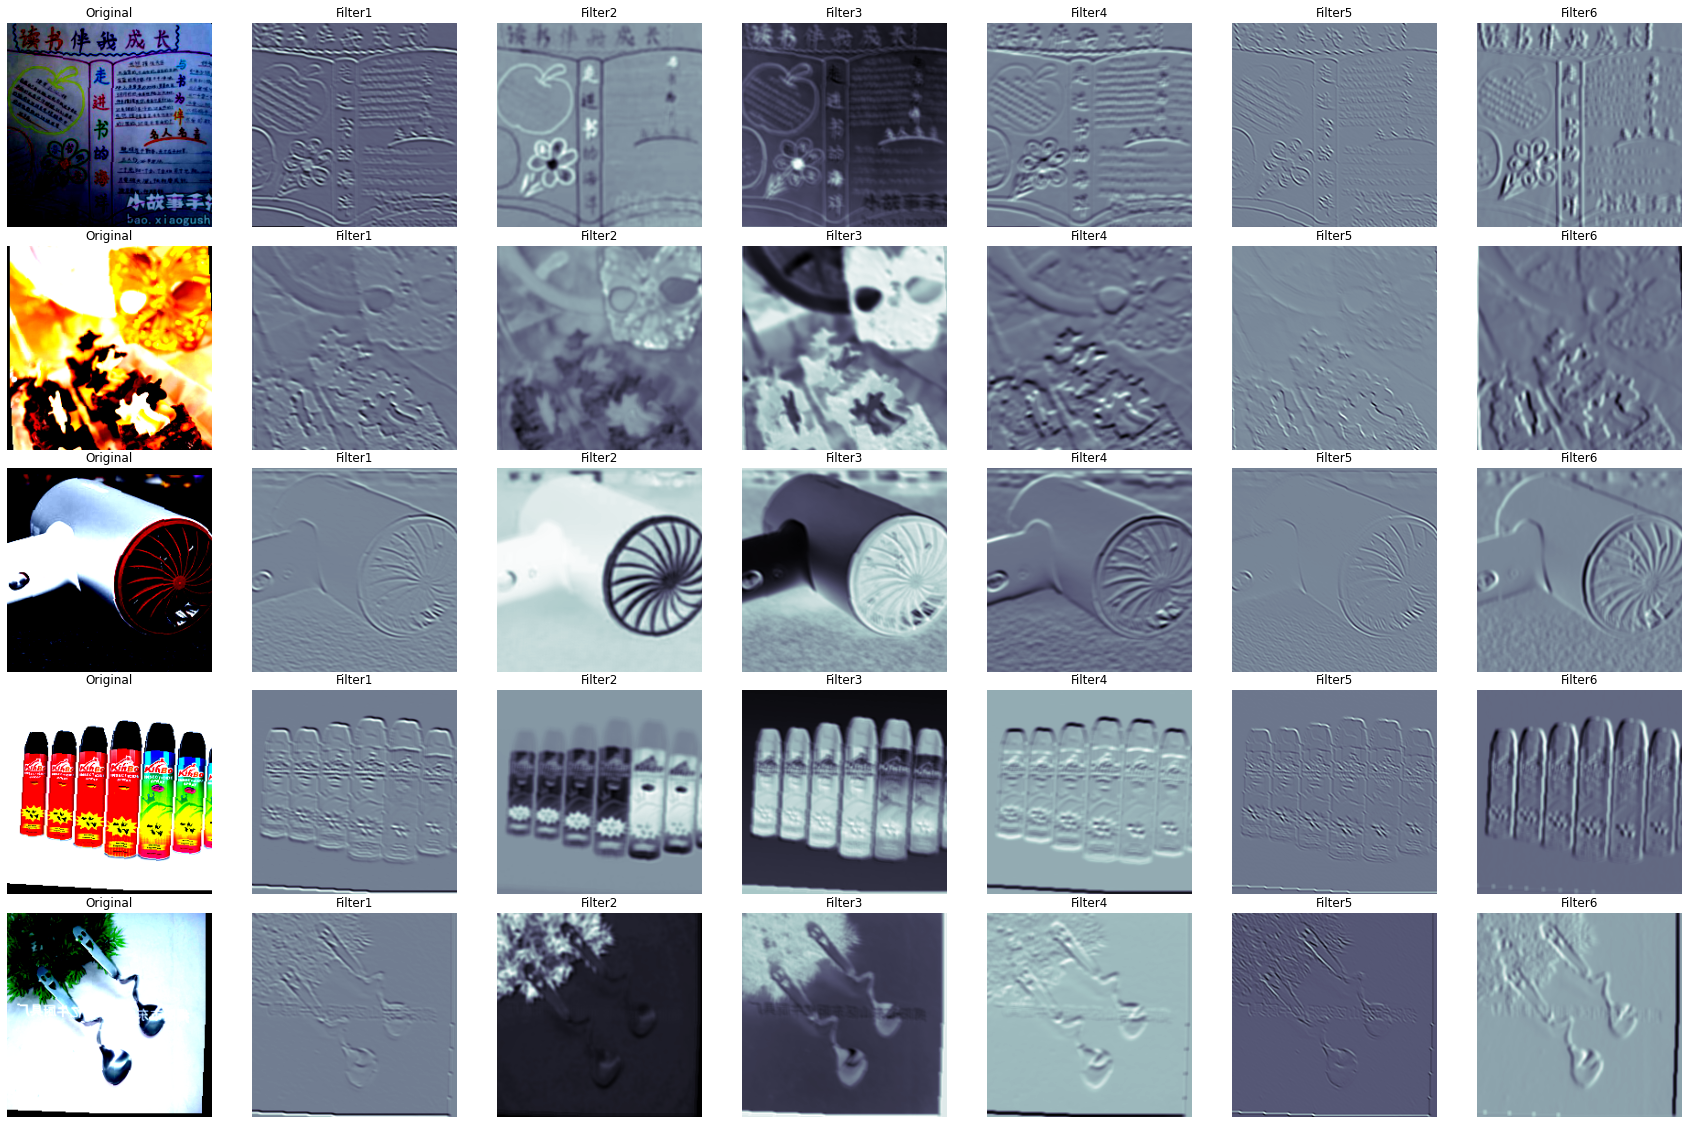

In [59]:
N_IMAGES = 5
N_FILTERS = 6

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images,filters,N_FILTERS)

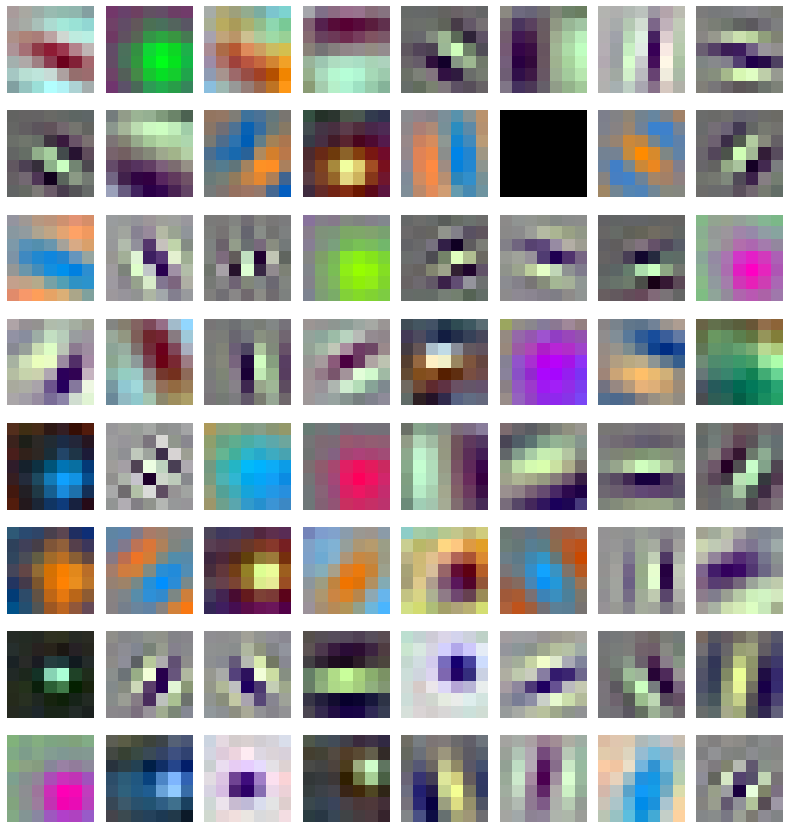

In [158]:
#plot the value of the filters themselves
def plot_filters(filters, normalize = True):
    filters = filters.cpu()
    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30,15))
    for i in range(rows*cols):
        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows,cols, i+1)
        ax.imshow(image.permute(1,2,0))
        ax.axis('off')

    fig.subplots_adjust(wspace=-0.9)
plot_filters(filters)

In [64]:
from keras.preprocessing import image
import numpy as np
img_path = r'E:\Machine_Learning\dataset\image-identification\Waste-picture\H-643.jpg'
img = image.load_img(img_path, target_size=(254, 254))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 500, 333, 3)
print(img_tensor.shape)


(1, 254, 254, 3)


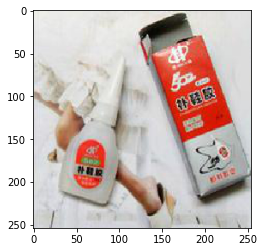

In [65]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [74]:
import cv2
import time
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

# savepath = r'features_whitegirl'
savepath = r"E:\manuscipt\hatmap_RGB_1"
# savepath='D:\hexiaojuan\coding\Unsupervised-Person-Re-identification-Clustering-and-Fine-tuning-master\dataset\DukeMTMC-reID\DukeMTMC-reID\bounding_box_test\0030_c1_f0056923'
if not os.path.exists(savepath):
    os.mkdir(savepath)


def draw_features(width, height, x, savename):
    tic = time.time()
    fig = plt.figure(figsize=(16, 16))
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.05, hspace=0.05)
    for i in range(width * height):
        plt.subplot(height, width, i + 1)
        plt.axis('off')
        img = x[0, i, :, :]
        pmin = np.min(img)
        pmax = np.max(img)
        img = ((img - pmin) / (pmax - pmin + 0.000001)) * 255  # float在[0，1]之间，转换成0-255
        img = img.astype(np.uint8)  # 转成unit8
        img = cv2.applyColorMap(img, cv2.COLORMAP_JET)  # 生成heat map
        img = img[:, :, ::-1]  # 注意cv2（BGR）和matplotlib(RGB)通道是相反的
        plt.imshow(img)
        print("{}/{}".format(i, width * height))
    fig.savefig(savename, dpi=100)
    fig.clf()
    plt.close()
    print("time:{}".format(time.time() - tic))


class ft_net(nn.Module):

    def __init__(self):
        super(ft_net, self).__init__()
        model_ft = models.resnet50(pretrained=True)
        self.model = model_ft

    def forward(self, x):
        if True:  # draw features or not
            x = self.model.conv1(x)
            draw_features(8, 8, x.cpu().numpy(), "{}/f1_conv1.png".format(savepath))

            x = self.model.bn1(x)
            draw_features(8, 8, x.cpu().numpy(), "{}/f2_bn1.png".format(savepath))

            x = self.model.relu(x)
            draw_features(8, 8, x.cpu().numpy(), "{}/f3_relu.png".format(savepath))

            x = self.model.maxpool(x)
            draw_features(8, 8, x.cpu().numpy(), "{}/f4_maxpool.png".format(savepath))

            x = self.model.layer1(x)
            draw_features(16, 16, x.cpu().numpy(), "{}/f5_layer1.png".format(savepath))

            x = self.model.layer2(x)
            draw_features(16, 32, x.cpu().numpy(), "{}/f6_layer2.png".format(savepath))

            x = self.model.layer3(x)
            draw_features(32, 32, x.cpu().numpy(), "{}/f7_layer3.png".format(savepath))

            x = self.model.layer4(x)
            draw_features(32, 32, x.cpu().numpy()[:, 0:1024, :, :], "{}/f8_layer4_1.png".format(savepath))
            draw_features(32, 32, x.cpu().numpy()[:, 1024:2048, :, :], "{}/f8_layer4_2.png".format(savepath))

            x = self.model.avgpool(x)
            plt.plot(np.linspace(1, 2048, 2048), x.cpu().numpy()[0, :, 0, 0])
            plt.savefig("{}/f9_avgpool.png".format(savepath))
            plt.clf()
            plt.close()

            x = x.view(x.size(0), -1)
            print(x)
            x = self.model.fc(x)
            plt.plot(np.linspace(1, 1000, 1000), x.cpu().numpy()[0, :])
            plt.savefig("{}/f10_fc.png".format(savepath))
            plt.clf()
            plt.close()
        else:
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.model.fc(x)

        return x


model = ft_net().cuda()

# pretrained_dict = resnet50.state_dict()
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# model_dict.update(pretrained_dict)
# net.load_state_dict(model_dict)
model.eval()
img = cv2.imread(r'E:\Machine_Learning\dataset\image-identification\Waste-picture\H-643.jpg')
img = cv2.resize(img, (224, 224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
img = transform(img).cuda()
img = img.unsqueeze(0)

with torch.no_grad():
    start = time.time()
    out = model(img)
    print("total time:{}".format(time.time() - start))
    result = out.cpu().numpy()
    # ind=np.argmax(out.cpu().numpy())
    ind = np.argsort(result, axis=1)
    for i in range(5):
        print("predict:top {} = cls {} : score {}".format(i + 1, ind[0, 1000 - i - 1], result[0, 1000 - i - 1]))
    print("done")

0/64
1/64
2/64
3/64
4/64
5/64
6/64
7/64
8/64
9/64
10/64
11/64
12/64
13/64
14/64
15/64
16/64
17/64
18/64
19/64
20/64
21/64
22/64
23/64
24/64
25/64
26/64
27/64
28/64
29/64
30/64
31/64
32/64
33/64
34/64
35/64
36/64
37/64
38/64
39/64
40/64
41/64
42/64
43/64
44/64
45/64
46/64
47/64
48/64
49/64
50/64
51/64
52/64
53/64
54/64
55/64
56/64
57/64
58/64
59/64
60/64
61/64
62/64
63/64
time:3.4376933574676514
0/64
1/64
2/64
3/64
4/64
5/64
6/64
7/64
8/64
9/64
10/64
11/64
12/64
13/64
14/64
15/64
16/64
17/64
18/64
19/64
20/64
21/64
22/64
23/64
24/64
25/64
26/64
27/64
28/64
29/64
30/64
31/64
32/64
33/64
34/64
35/64
36/64
37/64
38/64
39/64
40/64
41/64
42/64
43/64
44/64
45/64
46/64
47/64
48/64
49/64
50/64
51/64
52/64
53/64
54/64
55/64
56/64
57/64
58/64
59/64
60/64
61/64
62/64
63/64
time:2.4894731044769287
0/64
1/64
2/64
3/64
4/64
5/64
6/64
7/64
8/64
9/64
10/64
11/64
12/64
13/64
14/64
15/64
16/64
17/64
18/64
19/64
20/64
21/64
22/64
23/64
24/64
25/64
26/64
27/64
28/64
29/64
30/64
31/64
32/64
33/64
34/64
35/6

90/1024
91/1024
92/1024
93/1024
94/1024
95/1024
96/1024
97/1024
98/1024
99/1024
100/1024
101/1024
102/1024
103/1024
104/1024
105/1024
106/1024
107/1024
108/1024
109/1024
110/1024
111/1024
112/1024
113/1024
114/1024
115/1024
116/1024
117/1024
118/1024
119/1024
120/1024
121/1024
122/1024
123/1024
124/1024
125/1024
126/1024
127/1024
128/1024
129/1024
130/1024
131/1024
132/1024
133/1024
134/1024
135/1024
136/1024
137/1024
138/1024
139/1024
140/1024
141/1024
142/1024
143/1024
144/1024
145/1024
146/1024
147/1024
148/1024
149/1024
150/1024
151/1024
152/1024
153/1024
154/1024
155/1024
156/1024
157/1024
158/1024
159/1024
160/1024
161/1024
162/1024
163/1024
164/1024
165/1024
166/1024
167/1024
168/1024
169/1024
170/1024
171/1024
172/1024
173/1024
174/1024
175/1024
176/1024
177/1024
178/1024
179/1024
180/1024
181/1024
182/1024
183/1024
184/1024
185/1024
186/1024
187/1024
188/1024
189/1024
190/1024
191/1024
192/1024
193/1024
194/1024
195/1024
196/1024
197/1024
198/1024
199/1024
200/1024
201/1024
20

1009/1024
1010/1024
1011/1024
1012/1024
1013/1024
1014/1024
1015/1024
1016/1024
1017/1024
1018/1024
1019/1024
1020/1024
1021/1024
1022/1024
1023/1024
time:37.20005011558533
0/1024
1/1024
2/1024
3/1024
4/1024
5/1024
6/1024
7/1024
8/1024
9/1024
10/1024
11/1024
12/1024
13/1024
14/1024
15/1024
16/1024
17/1024
18/1024
19/1024
20/1024
21/1024
22/1024
23/1024
24/1024
25/1024
26/1024
27/1024
28/1024
29/1024
30/1024
31/1024
32/1024
33/1024
34/1024
35/1024
36/1024
37/1024
38/1024
39/1024
40/1024
41/1024
42/1024
43/1024
44/1024
45/1024
46/1024
47/1024
48/1024
49/1024
50/1024
51/1024
52/1024
53/1024
54/1024
55/1024
56/1024
57/1024
58/1024
59/1024
60/1024
61/1024
62/1024
63/1024
64/1024
65/1024
66/1024
67/1024
68/1024
69/1024
70/1024
71/1024
72/1024
73/1024
74/1024
75/1024
76/1024
77/1024
78/1024
79/1024
80/1024
81/1024
82/1024
83/1024
84/1024
85/1024
86/1024
87/1024
88/1024
89/1024
90/1024
91/1024
92/1024
93/1024
94/1024
95/1024
96/1024
97/1024
98/1024
99/1024
100/1024
101/1024
102/1024
103/1024
1

915/1024
916/1024
917/1024
918/1024
919/1024
920/1024
921/1024
922/1024
923/1024
924/1024
925/1024
926/1024
927/1024
928/1024
929/1024
930/1024
931/1024
932/1024
933/1024
934/1024
935/1024
936/1024
937/1024
938/1024
939/1024
940/1024
941/1024
942/1024
943/1024
944/1024
945/1024
946/1024
947/1024
948/1024
949/1024
950/1024
951/1024
952/1024
953/1024
954/1024
955/1024
956/1024
957/1024
958/1024
959/1024
960/1024
961/1024
962/1024
963/1024
964/1024
965/1024
966/1024
967/1024
968/1024
969/1024
970/1024
971/1024
972/1024
973/1024
974/1024
975/1024
976/1024
977/1024
978/1024
979/1024
980/1024
981/1024
982/1024
983/1024
984/1024
985/1024
986/1024
987/1024
988/1024
989/1024
990/1024
991/1024
992/1024
993/1024
994/1024
995/1024
996/1024
997/1024
998/1024
999/1024
1000/1024
1001/1024
1002/1024
1003/1024
1004/1024
1005/1024
1006/1024
1007/1024
1008/1024
1009/1024
1010/1024
1011/1024
1012/1024
1013/1024
1014/1024
1015/1024
1016/1024
1017/1024
1018/1024
1019/1024
1020/1024
1021/1024
1022/1024
1023/

820/1024
821/1024
822/1024
823/1024
824/1024
825/1024
826/1024
827/1024
828/1024
829/1024
830/1024
831/1024
832/1024
833/1024
834/1024
835/1024
836/1024
837/1024
838/1024
839/1024
840/1024
841/1024
842/1024
843/1024
844/1024
845/1024
846/1024
847/1024
848/1024
849/1024
850/1024
851/1024
852/1024
853/1024
854/1024
855/1024
856/1024
857/1024
858/1024
859/1024
860/1024
861/1024
862/1024
863/1024
864/1024
865/1024
866/1024
867/1024
868/1024
869/1024
870/1024
871/1024
872/1024
873/1024
874/1024
875/1024
876/1024
877/1024
878/1024
879/1024
880/1024
881/1024
882/1024
883/1024
884/1024
885/1024
886/1024
887/1024
888/1024
889/1024
890/1024
891/1024
892/1024
893/1024
894/1024
895/1024
896/1024
897/1024
898/1024
899/1024
900/1024
901/1024
902/1024
903/1024
904/1024
905/1024
906/1024
907/1024
908/1024
909/1024
910/1024
911/1024
912/1024
913/1024
914/1024
915/1024
916/1024
917/1024
918/1024
919/1024
920/1024
921/1024
922/1024
923/1024
924/1024
925/1024
926/1024
927/1024
928/1024
929/1024
930/1024
9